PHASE1


ویژگی های دیگه مثل مساحت و ...
شناسایی رنگ های غالب
تبدیل الگوریتم ها به manual

In [1]:
import os


In [2]:

import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern

In [3]:
# تنظیمات اولیه
IMAGE_SIZE = (256, 256)  # تغییر اندازه تصاویر به 256x256

def preprocess_image(image_path):
    """
    خواندن تصویر با cv2، تغییر اندازه و تبدیل به خاکستری.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"عدم توانایی در خواندن تصویر: {image_path}")
    # تغییر اندازه تصویر
    # img = cv2.resize(img, IMAGE_SIZE)
    img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    # تبدیل به خاکستری
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 
    gray = cv2.equalizeHist(gray)
    return img, gray


In [4]:
COLOR_MAP = {
    "White": (0, 30, 200),
    "Gray": (0, 30, 125),
    "Dark Gray": (0, 30, 30),
    "Nude": (30, 80, 150),
    "Blue": (120, 100, 150),
    "Green": (60, 100, 150),
}

COLOR_LABELS = list(COLOR_MAP.keys())
COLOR_VALUES = np.array(list(COLOR_MAP.values()))

def extract_color_feature_string(img):
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_mean, s_mean, v_mean = np.mean(img_hsv[:, :, 0]), np.mean(img_hsv[:, :, 1]), np.mean(img_hsv[:, :, 2])

    # Compute the Euclidean distance to predefined colors
    distances = np.linalg.norm(COLOR_VALUES - np.array([h_mean, s_mean, v_mean]), axis=1)

    # Find the nearest color category
    nearest_color_index = np.argmin(distances)
    return nearest_color_index  # Returns the category index (0 to 5)


In [5]:
def extract_statistical_feature(gray):
    """
    محاسبه آنتروپی تصویر خاکستری به عنوان شاخص توزیع شدت روشنایی.
    """
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    # جلوگیری از log صفر
    hist = np.where(hist == 0, 1, hist)
    entropy = -np.sum(hist * np.log2(hist))
    return entropy


In [6]:
EDGE_MAP = {
    "Very Low Edge": 0,
    "Low Edge": 1,
    "Medium-Low Edge": 2,
    "Medium-High Edge": 3,
    "High Edge": 4,
    "Very High Edge": 5
}

def manual_edge_detection(image_gray):
    """
    Classifies an image's edge density into 6 levels based on Laplacian variance.
    """
    laplacian_var = cv2.Laplacian(image_gray, cv2.CV_64F).var()

    # Define edge density categories with 6 levels
    if laplacian_var < 10:
        return EDGE_MAP["Very Low Edge"]
    elif 10 <= laplacian_var < 30:
        return EDGE_MAP["Low Edge"]
    elif 30 <= laplacian_var < 60:
        return EDGE_MAP["Medium-Low Edge"]
    elif 60 <= laplacian_var < 100:
        return EDGE_MAP["Medium-High Edge"]
    elif 100 <= laplacian_var < 200:
        return EDGE_MAP["High Edge"]
    else:
        return EDGE_MAP["Very High Edge"]


In [7]:

def manual_lbp(gray_img):
    """
    Manually computes the Local Binary Pattern (LBP) of a grayscale image.
    
    Parameters:
        gray_img (numpy.ndarray): Grayscale input image.
    
    Returns:
        lbp_image (numpy.ndarray): Image with LBP values.
        lbp_mean (float): Mean of the LBP values (can be used as a feature).
    """
    h, w = gray_img.shape
    lbp_image = np.zeros((h-2, w-2), dtype=np.uint8)  # avoid border pixels

    for i in range(1, h-1):
        for j in range(1, w-1):
            center = gray_img[i, j]
            binary_string = ''
            binary_string += '1' if gray_img[i-1, j-1] >= center else '0'  # top-left
            binary_string += '1' if gray_img[i-1, j] >= center else '0'    # top
            binary_string += '1' if gray_img[i-1, j+1] >= center else '0'  # top-right
            binary_string += '1' if gray_img[i, j+1] >= center else '0'    # right
            binary_string += '1' if gray_img[i+1, j+1] >= center else '0'  # bottom-right
            binary_string += '1' if gray_img[i+1, j] >= center else '0'    # bottom
            binary_string += '1' if gray_img[i+1, j-1] >= center else '0'  # bottom-left
            binary_string += '1' if gray_img[i, j-1] >= center else '0'    # left
            
            lbp_value = int(binary_string, 2)
            lbp_image[i-1, j-1] = lbp_value

    lbp_mean = np.mean(lbp_image)
    return lbp_mean

In [8]:
TEXTURE_MAP = {
    "Very Soft": 0,
    "Soft": 1,
    "Slightly Curly": 2,
    "Curly": 3,
    "Slightly Straight": 4,
    "Straight": 5
}

def extract_texture_feature(gray):
    """
    Classifies an image texture into 6 levels based on Local Binary Patterns (LBP).
    """
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_mean = np.mean(lbp)

    # Define thresholds for 6-level texture classification
    if lbp_mean < 0.1:
        return TEXTURE_MAP["Very Soft"]
    elif 0.1 <= lbp_mean < 0.25:
        return TEXTURE_MAP["Soft"]
    elif 0.25 <= lbp_mean < 0.4:
        return TEXTURE_MAP["Slightly Curly"]
    elif 0.4 <= lbp_mean < 0.6:
        return TEXTURE_MAP["Curly"]
    elif 0.6 <= lbp_mean < 0.8:
        return TEXTURE_MAP["Slightly Straight"]
    else:
        return TEXTURE_MAP["Straight"]


In [9]:
def extract_curviness_feature(img_gray):
    edges = cv2.Canny(img_gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    total_curviness = 0
    for cnt in contours:
        length = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * length, True)
        total_curviness += (len(cnt) - len(approx))  # More difference = more curvature

    return total_curviness / max(1, len(contours))

In [10]:
def extract_hu_feature(gray):
    """
    استخراج ویژگی Hu Moments: محاسبه Hu Moments و ترکیب آن‌ها به صورت یک مقدار (جمع مطلق مقادیر)
    """
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments).flatten()
    hu_feature = np.sum(np.abs(hu_moments))
    return hu_feature

In [11]:
def extract_laplacian_variance(gray):
    """
    استخراج ویژگی واریانس لاپلاس به عنوان شاخص شفافیت/تمرکز تصویر.
    """
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    variance = laplacian.var()
    return variance

In [12]:
def gabor_filters(gray_img, frequencies=[0.1, 0.2, 0.3], thetas=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """
    Apply a bank of Gabor filters and return the mean response as a texture descriptor.

    Parameters:
        gray_img (ndarray): Input grayscale image.
        frequencies (list): List of frequencies for the Gabor kernel.
        thetas (list): List of orientations (in radians).

    Returns:
        float: Mean value of the maximum Gabor response across all filters.
    """
    responses = []

    for theta in thetas:
        for freq in frequencies:
            kernel = cv2.getGaborKernel((21, 21), 4.0, theta, 1.0/freq, 0.5, 0, ktype=cv2.CV_32F)
            filtered = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)
            mean_response = filtered.mean()
            responses.append(mean_response)
    
    return np.mean(responses)  # or np.max(responses) if you want the strongest texture

In [13]:
import cv2
import numpy as np

def extract_manual_hog(gray, cell_size=8, block_size=2, bins=9):
    """
    Manually computes Histogram of Oriented Gradients (HOG) for a grayscale image.

    Args:
        gray: Grayscale image (2D array).
        cell_size: Size of each cell in pixels (default 8x8).
        block_size: Number of cells per block (default 2x2).
        bins: Number of orientation bins (default 9).

    Returns:
        1D array of HOG features.
    """
    # Step 1: Compute gradients
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=1)
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    # Normalize angle to [0,180)
    angle = angle % 180

    h, w = gray.shape
    n_cells_x = w // cell_size
    n_cells_y = h // cell_size

    # Step 2: Initialize histogram for each cell
    hist_tensor = np.zeros((n_cells_y, n_cells_x, bins), dtype=np.float32)

    bin_width = 180 / bins

    for i in range(n_cells_y):
        for j in range(n_cells_x):
            # Extract cell's magnitude and angle
            mag_cell = magnitude[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            ang_cell = angle[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]

            # Histogram for the cell
            for k in range(cell_size):
                for l in range(cell_size):
                    mag = mag_cell[k, l]
                    ang = ang_cell[k, l]
                    bin_idx = int(ang // bin_width) % bins
                    hist_tensor[i, j, bin_idx] += mag

    # Step 3: Normalize across blocks
    hog_features = []
    for i in range(n_cells_y - block_size + 1):
        for j in range(n_cells_x - block_size + 1):
            block = hist_tensor[i:i+block_size, j:j+block_size, :].flatten()
            norm = np.linalg.norm(block) + 1e-6
            block = block / norm
            hog_features.extend(block)    

    return np.sum(np.array(hog_features) ** 2)


In [14]:
def compute_glcm(gray, distance=1, angle=0, levels=8):
    """
    Manually computes the GLCM of a grayscale image.
    """
    # Resize grayscale levels
    gray = (gray / (256 // levels)).astype(np.uint8)

    dx = int(np.round(np.cos(angle)))
    dy = int(np.round(np.sin(angle)))

    glcm = np.zeros((levels, levels), dtype=np.float64)

    rows, cols = gray.shape
    for i in range(rows - dy):
        for j in range(cols - dx):
            row = gray[i, j]
            col = gray[i + dy, j + dx]
            glcm[row, col] += 1

    glcm += glcm.T  # Make it symmetric
    glcm /= np.sum(glcm)  # Normalize
    return glcm


def glcm_contrast_homogeneity(gray):
    glcm = compute_glcm(gray, distance=1, angle=0, levels=8)

    levels = glcm.shape[0]
    contrast = 0
    homogeneity = 0

    for i in range(levels):
        for j in range(levels):
            contrast += (i - j) ** 2 * glcm[i, j]
            homogeneity += glcm[i, j] / (1 + abs(i - j))

    return contrast

In [15]:
def compute_brightness(img):
    """
    Computes the average brightness of an image.
    Works for both grayscale and color images.
    Returns a float between 0 (black) and 255 (white).
    """
    if len(img.shape) == 3:
        # Convert color image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    brightness = np.mean(gray)
    return brightness

In [16]:
def harris_corners_score(image_gray, block_size=2, ksize=3, k=0.04, threshold_ratio=0.01):
    """
    Computes a score based on the number of Harris corners in a grayscale image.
    Returns the number of strong corners detected (int).
    """
    # Convert to float32
    gray = np.float32(image_gray)

    # Detect corners
    dst = cv2.cornerHarris(gray, block_size, ksize, k)

    # Normalize response
    dst = cv2.dilate(dst, None)
    threshold = threshold_ratio * dst.max()

    # Count strong corner responses
    corner_count = np.sum(dst > threshold)

    return int(corner_count)

In [17]:
def fourier_features(image_gray):
    """
    Computes a single numerical Fourier feature by summing high-frequency magnitudes.
    Returns a float value representing frequency complexity.
    """
    # Apply 2D FFT
    f = np.fft.fft2(image_gray)
    fshift = np.fft.fftshift(f)  # Center low freq
    magnitude_spectrum = np.abs(fshift)

    # Normalize
    magnitude_spectrum = np.log1p(magnitude_spectrum)

    # Get image dimensions
    h, w = image_gray.shape
    center_x, center_y = w // 2, h // 2

    # Mask to remove low frequency area in the center
    radius = 30  # change this to adjust the frequency range
    y, x = np.ogrid[:h, :w]
    mask = ((x - center_x)**2 + (y - center_y)**2) >= radius**2

    # High frequency energy sum
    high_freq_energy = np.sum(magnitude_spectrum[mask])

    return float(high_freq_energy)

In [18]:
def extract_features(image_path):
    """
    استخراج تمامی ویژگی‌های مورد نیاز از یک تصویر.
    """
    try:
        img_color, img_gray = preprocess_image(image_path)
    except Exception as e:
        print(e)
        return None
        
    # ویژگی‌های آماری جدید    

    color_feat = extract_color_feature_string(img_color)          # 1 ویژگی ترکیبی رنگ
    stat_feat = extract_statistical_feature(img_gray)        # 1 ویژگی آماری (آنتروپی)
    #edge_feat = manual_edge_detection(img_gray)              # 1 ویژگی لبه‌ای (چگالی لبه)
    #texture_feat = extract_texture_feature(img_gray)         # 1 ویژگی بافتی ترکیبی (میانگین LBP)
    hu_feat = extract_hu_feature(img_gray)                   # 1 ویژگی Hu Moments ترکیبی
    laplacian_var = extract_laplacian_variance(img_gray)      # 1 ویژگی واریانس لاپلاس
    curve_feat = extract_curviness_feature(img_gray)
    #lbp_feat = manual_lbp(img_gray)
    gabor_feat = gabor_filters(img_gray)
    hog_feat = extract_manual_hog(img_gray)
    homogeneity = glcm_contrast_homogeneity(img_gray)
    brightness = compute_brightness(img_color)
    haris_corner = harris_corners_score(img_gray)
    fourier_feat = fourier_features(img_gray)
    
    # ترکیب تمام ویژگی‌ها (مجموعاً 1+4+1+1+1+1+1 = 10 ویژگی)
    # features = [color_feat] + stat_features + [entropy, edge_feat, texture_feat, hu_feat, laplacian_var]
    

    # ترکیب تمامی ویژگی‌ها در یک لیست (به تعداد 6 ویژگی)
    features = [color_feat, hu_feat, laplacian_var, curve_feat, gabor_feat, hog_feat, homogeneity, brightness, haris_corner, fourier_feat]
    return features


In [19]:
def process_dataset(root_dir, output_csv="features.csv"):
    """
    پردازش تمامی تصاویر موجود در پوشه train (که شامل ۶ زیرپوشه مربوط به کلاس‌هاست)
    و ذخیره ویژگی‌های استخراج شده در یک فایل CSV.
    """
    feature_list = []
    image_names = []
    labels = []

    # from sklearn.preprocessing import StandardScaler

    # scaler = StandardScaler()
    # scaled_features = scaler.fit_transform(feature_list)
    # df = pd.DataFrame(scaled_features, columns=columns)

    # پیمایش در سطح زیرپوشه‌های کلاس
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                    image_path = os.path.join(class_path, file)
                    features = extract_features(image_path)
                    if features is not None:
                        feature_list.append(features)
                        image_names.append(file)
                        labels.append(class_name)
    
    # نام ستون‌ها: ویژگی‌های ترکیبی
    columns = ['color', 'hu_sum', 'laplacian_var', 'curve', 'gabor', 'HOG', 'homogeneity', 'brightness', 'haris_corner', 'fourier']
    df = pd.DataFrame(feature_list, columns=columns)
    df.insert(0, "image_name", image_names)
    df.insert(1, "class", labels)
    df.to_csv(output_csv, index=False)
    print(f"ویژگی‌ها در فایل {output_csv} ذخیره شدند.")

In [30]:
if __name__ == "__main__":
    # مسیر پوشه train را تنظیم کنید (مثلاً "train")
    train_directory = "train"
    process_dataset(train_directory)


ویژگی‌ها در فایل features.csv ذخیره شدند.


PHASE2

In [4]:
import pandas as pd
import numpy as np

def compute_correlation(x, y):
    """
    محاسبه ضریب همبستگی پیرسون بین دو بردار x و y به صورت دستی.
    """
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sqrt(np.sum((x - mean_x)**2) * np.sum((y - mean_y)**2))
    if denominator == 0:
        return 0
    return numerator / denominator

def compute_correlation_matrix(data):
    """
    محاسبه ماتریس همبستگی برای داده‌ها.
    data: آرایه‌ای با ابعاد (n_samples, n_features)
    """
    n_features = data.shape[1]
    corr_matrix = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(n_features):
            corr_matrix[i, j] = compute_correlation(data[:, i], data[:, j])
    return corr_matrix

def select_features(corr_matrix, threshold=0.7):
    """
    انتخاب ویژگی‌ها بر اساس ماتریس همبستگی.
    اگر همبستگی دو ویژگی بالای threshold باشد، یکی از آن‌ها حذف می‌شود.
    """
    n = corr_matrix.shape[0]
    selected = list(range(n))
    # بررسی هر جفت ویژگی
    for i in range(n):
        for j in range(i + 1, n):
            if abs(corr_matrix[i, j]) > threshold:
                # اگر هر دو ویژگی همچنان انتخاب شده‌اند
                if i in selected and j in selected:
                    # محاسبه میانگین همبستگی هر ویژگی با بقیه ویژگی‌ها
                    avg_i = np.mean(np.delete(corr_matrix[i, :], i))
                    avg_j = np.mean(np.delete(corr_matrix[j, :], j))
                    # حذف آن ویژگی که دارای میانگین همبستگی بالاتر است
                    if avg_i > avg_j:
                        if i in selected:
                            selected.remove(i)
                    else:
                        if j in selected:
                            selected.remove(j)

    
    return selected

def main():
    # فرض کنید فایل CSV خروجی فاز اول با نام features.csv ذخیره شده است.
    # فایل شامل ستون‌های: image_name, class, color_mean, entropy, edge_density, lbp_mean, hu_sum, laplacian_var
    df = pd.read_csv("features.csv")
    feature_columns = ['color', 'hu_sum', 'laplacian_var', 'curve', 'gabor', 'homogeneity', 'brightness', 'haris_corner', 'fourier']
    data = df[feature_columns].values

    # محاسبه ماتریس همبستگی
    corr_matrix = compute_correlation_matrix(data)
    print("ماتریس همبستگی:")
    print(corr_matrix)
    
    threshold = 0.4 # انتخاب شده به دلیل حذف ویژگی‌های تکراری در صورتی که همبستگی آن‌ها بیش ا70 درصد باشد.
    selected_indices = select_features(corr_matrix, threshold=threshold)
    
    print(f"\nاندیس‌های انتخاب شده با آستانه {threshold}: {selected_indices}")
    selected_features = [feature_columns[i] for i in selected_indices]
    print(f"ویژگی‌های انتخاب شده: {selected_features}")

if __name__ == "__main__":
    main()


ماتریس همبستگی:
[[ 1.         -0.28817406 -0.19314283 -0.06082189 -0.22208461 -0.21682603
  -0.25575679  0.02908793 -0.28221381]
 [-0.28817406  1.          0.32850581  0.10578785  0.38839909  0.40667379
  -0.109183    0.34890586  0.353985  ]
 [-0.19314283  0.32850581  1.         -0.37028015  0.84378577  0.94178136
  -0.30513335  0.66525343  0.89443541]
 [-0.06082189  0.10578785 -0.37028015  1.         -0.38538606 -0.25652806
   0.26005928 -0.09016715 -0.41476785]
 [-0.22208461  0.38839909  0.84378577 -0.38538606  1.          0.87086285
  -0.30020807  0.75095531  0.90455972]
 [-0.21682603  0.40667379  0.94178136 -0.25652806  0.87086285  1.
  -0.29296827  0.75614511  0.86568209]
 [-0.25575679 -0.109183   -0.30513335  0.26005928 -0.30020807 -0.29296827
   1.         -0.35560647 -0.26798476]
 [ 0.02908793  0.34890586  0.66525343 -0.09016715  0.75095531  0.75614511
  -0.35560647  1.          0.60977526]
 [-0.28221381  0.353985    0.89443541 -0.41476785  0.90455972  0.86568209
  -0.26798476 

PHASE3 and PHASE4 and PHASE5

KMEANS

k=2: Distortion=14351.21, Silhouette=0.217
k=3: Distortion=11183.60, Silhouette=0.241
k=4: Distortion=9591.99, Silhouette=0.256
k=5: Distortion=8909.21, Silhouette=0.221
k=6: Distortion=7683.54, Silhouette=0.279
k=7: Distortion=7110.47, Silhouette=0.275
k=8: Distortion=6663.03, Silhouette=0.252
k=9: Distortion=6102.67, Silhouette=0.257
k=10: Distortion=5783.90, Silhouette=0.259


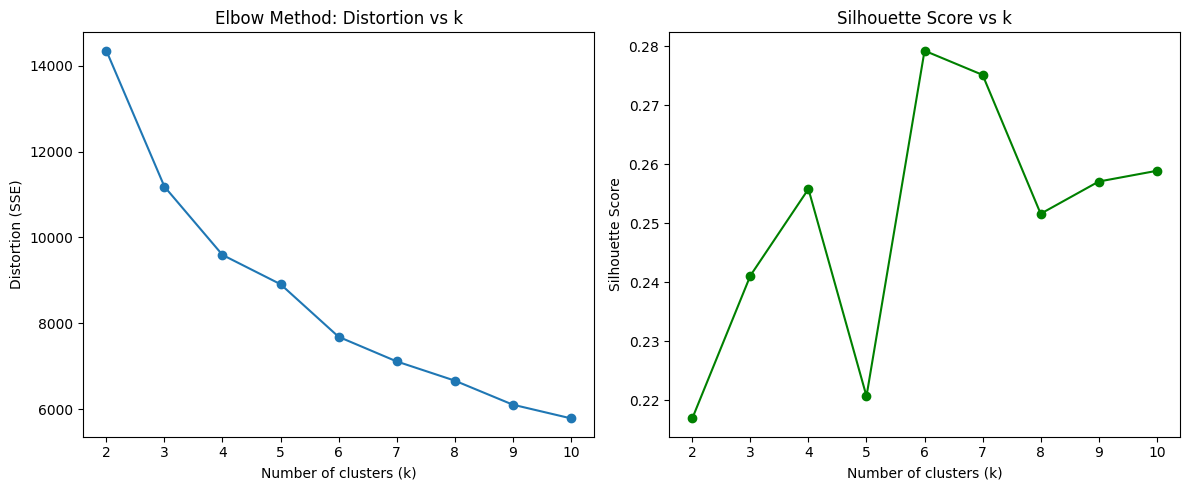

بهترین تعداد خوشه (k) انتخاب شده: 6


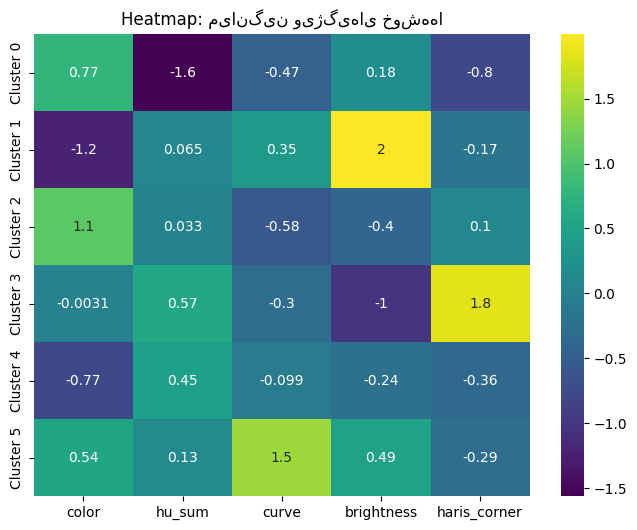

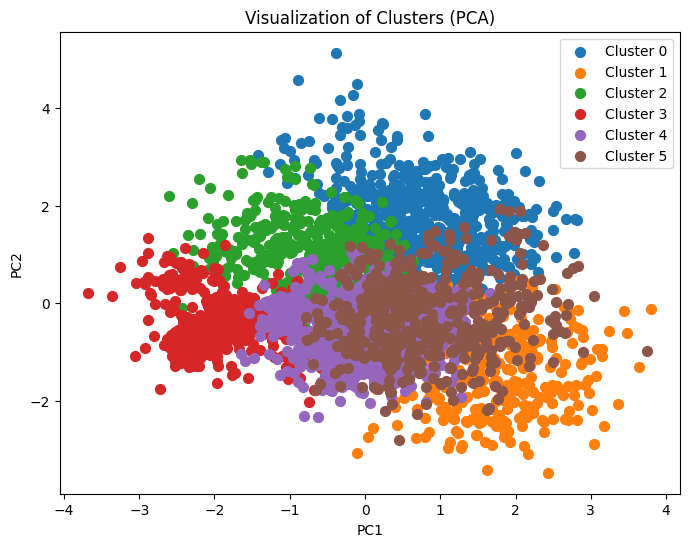

Silhouette Score خوشه‌بندی نهایی: 0.269
ماتریس سردرگمی دستی:
[[373  26  80   1  41  79]
 [  9   0  12  19 448 112]
 [ 26 313  19  12  51 179]
 [  1   0  44 510  36   9]
 [ 17   3  28   0 508  44]
 [166   0 322  15  27  70]]
نگاشت خوشه به برچسب واقعی (دستی):
{3: 'forest', 4: 'intersection', 0: 'beach', 2: 'sea_ice', 1: 'desert', 5: 'dense_residential'}
Precision (دستی): 0.630
Recall (دستی): 0.594
F1-Score (دستی): 0.592


In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


##############################
# پیاده‌سازی دستی KMeans (با بردارسازی)
##############################
def initialize_centroids(X, k):
    indices = np.random.choice(len(X), k, replace=False)
    return X[indices].copy()

def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    centroids = []
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroids.append(np.mean(cluster_points, axis=0))
        else:
            centroids.append(np.zeros(X.shape[1]))
    return np.array(centroids)

def manual_kmeans(X, k, max_iter=100, tol=1e-4):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iter):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids
    return labels, centroids

def compute_distortion(X, labels, centroids):
    dists = np.linalg.norm(X - centroids[labels], axis=1)**2
    return np.sum(dists)

def manual_silhouette_score(X, labels):
    N = len(X)
    D = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)
    s = np.zeros(N)
    unique_clusters = np.unique(labels)
    for i in range(N):
        same_mask = (labels == labels[i])
        same_mask[i] = False
        a = np.mean(D[i, same_mask]) if np.any(same_mask) else 0
        b = np.inf
        for cl in unique_clusters:
            if cl == labels[i]:
                continue
            other_mask = (labels == cl)
            if np.any(other_mask):
                avg_dist = np.mean(D[i, other_mask])
                if avg_dist < b:
                    b = avg_dist
        s[i] = 0 if max(a, b) == 0 else (b - a) / max(a, b)
    return np.mean(s)

##############################
# ارزیابی خارجی: محاسبه دستی Precision، Recall، F1-Score
##############################
def manual_confusion_matrix(true_labels, pred_labels, classes_true, classes_pred):
    cm = np.zeros((len(classes_true), len(classes_pred)), dtype=int)
    for i in range(len(true_labels)):
        t_idx = classes_true.index(true_labels[i])
        p_idx = classes_pred.index(pred_labels[i])
        cm[t_idx, p_idx] += 1
    return cm

def greedy_assignment(cm, classes_true, classes_pred):
    mapping = {}
    cm_copy = cm.copy()
    assigned_true = set()
    assigned_pred = set()
    while np.max(cm_copy) > 0:
        idx = np.unravel_index(np.argmax(cm_copy, axis=None), cm_copy.shape)
        i, j = idx  # i: اندیس کلاس واقعی، j: اندیس خوشه
        if i not in assigned_true and j not in assigned_pred:
            mapping[classes_pred[j]] = classes_true[i]
            assigned_true.add(i)
            assigned_pred.add(j)
        cm_copy[i, j] = 0
    return mapping

def compute_precision_recall_f1(true_labels, mapped_labels, classes):
    precisions, recalls, f1s = [], [], []
    for cl in classes:
        tp = sum((true_labels[i]==cl and mapped_labels[i]==cl) for i in range(len(true_labels)))
        fp = sum((true_labels[i]!=cl and mapped_labels[i]==cl) for i in range(len(true_labels)))
        fn = sum((true_labels[i]==cl and mapped_labels[i]!=cl) for i in range(len(true_labels)))
        prec = tp/(tp+fp) if (tp+fp)>0 else 0
        rec = tp/(tp+fn) if (tp+fn)>0 else 0
        f1 = (2*prec*rec/(prec+rec)) if (prec+rec)>0 else 0
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

##############################
# Clustering، Visualization، Evaluation
##############################
def clustering_phase():
    # بارگذاری داده‌های استخراج شده (features.csv) که شامل ستون‌های:
    # 'color_mean', 'entropy', 'edge_density', 'lbp_mean', 'hu_sum', 'laplacian_var', و 'class' می‌باشد.
    df = pd.read_csv("features.csv")
    feature_columns = ['color', 'hu_sum', 'curve', 'brightness', 'haris_corner']

    # گرفتن داده‌ها و نرمال‌سازی ویژگی‌ها
    X_raw = df[feature_columns].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)

    # Elbow Method: محاسبه Distortion و Silhouette Score برای k های مختلف
    k_range = range(2, 11)
    distortions, sil_scores = [], []
    for k in k_range:
        labels, centroids = manual_kmeans(X, k)
        distortion = compute_distortion(X, labels, centroids)
        distortions.append(distortion)
        sil = manual_silhouette_score(X, labels) if len(np.unique(labels)) > 1 else -1
        sil_scores.append(sil)
        print(f"k={k}: Distortion={distortion:.2f}, Silhouette={sil:.3f}")
    
    # رسم نمودار Elbow و Silhouette Score
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(list(k_range), distortions, marker='o')
    plt.title("Elbow Method: Distortion vs k")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Distortion (SSE)")
    
    plt.subplot(1,2,2)
    plt.plot(list(k_range), sil_scores, marker='o', color='green')
    plt.title("Silhouette Score vs k")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.tight_layout()
    plt.show()
    
    # انتخاب بهترین k بر اساس بیشترین Silhouette Score
    best_k = k_range[np.argmax(sil_scores)]
    
    print(f"بهترین تعداد خوشه (k) انتخاب شده: {best_k}")
    
    # اجرای KMeans دستی با بهترین k
    final_labels, final_centroids = manual_kmeans(X, best_k)
    df["cluster"] = final_labels
    df.to_csv("features_with_clusters.csv", index=False)
    
    # رسم Heatmap میانگین ویژگی‌های هر خوشه
    clusters = np.unique(final_labels)
    cluster_means = np.array([np.mean(X[final_labels == cl], axis=0) for cl in clusters])
    plt.figure(figsize=(8,6))
    sns.heatmap(cluster_means, annot=True, cmap="viridis", xticklabels=feature_columns,
                yticklabels=[f"Cluster {cl}" for cl in clusters])
    plt.title("Heatmap: میانگین ویژگی‌های خوشه‌ها")
    plt.show()
    
    # Visualization: کاهش ابعاد با PCA و scatter plot
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8,6))
    for cl in clusters:
        idx = final_labels == cl
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Cluster {cl}", s=50)
    plt.title("Visualization of Clusters (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()
    
    # Evaluation داخلی: محاسبه Silhouette Score
    sil = manual_silhouette_score(X, final_labels)
    print(f"Silhouette Score خوشه‌بندی نهایی: {sil:.3f}")
    
    # ارزیابی خارجی: اگر برچسب‌های واقعی (ستون "class") موجود باشند
    if "class" in df.columns:
        true_labels = df["class"].tolist()
        pred_clusters = df["cluster"].tolist()
        # تعیین لیست کلاس‌های واقعی و خوشه‌های پیش‌بینی شده
        classes_true = sorted(list(set(true_labels)))
        classes_pred = sorted(list(set(pred_clusters)))
        # محاسبه ماتریس سردرگمی به صورت دستی
        cm = manual_confusion_matrix(true_labels, pred_clusters, classes_true, classes_pred)
        print("ماتریس سردرگمی دستی:")
        print(cm)
        # نگاشت خوشه به برچسب واقعی با الگوریتم greedy
        mapping = greedy_assignment(cm, classes_true, classes_pred)
        print("نگاشت خوشه به برچسب واقعی (دستی):")
        print(mapping)
        # اعمال نگاشت روی برچسب‌های پیش‌بینی شده
        mapped_labels = [mapping[cl] if cl in mapping else None for cl in pred_clusters]
        # محاسبه Precision، Recall و F1-Score به صورت دستی (macro-averaged)
        macro_prec, macro_rec, macro_f1 = compute_precision_recall_f1(true_labels, mapped_labels, classes_true)
        print(f"Precision (دستی): {macro_prec:.3f}")
        print(f"Recall (دستی): {macro_rec:.3f}")
        print(f"F1-Score (دستی): {macro_f1:.3f}")

if __name__ == "__main__":
    clustering_phase()


MEANSHIFT1

Estimated base bandwidth: 2.38
Bandwidth=1.429 → Clusters=12, Silhouette=0.237
Bandwidth=1.530 → Clusters=7, Silhouette=0.151
Bandwidth=1.630 → Clusters=7, Silhouette=0.154
Bandwidth=1.730 → Clusters=4, Silhouette=0.172
Bandwidth=1.830 → Clusters=3, Silhouette=0.195
Bandwidth=1.931 → Clusters=1, Silhouette=-1.000
Bandwidth=2.031 → Clusters=1, Silhouette=-1.000
Bandwidth=2.131 → Clusters=1, Silhouette=-1.000
Bandwidth=2.232 → Clusters=1, Silhouette=-1.000
Bandwidth=2.332 → Clusters=1, Silhouette=-1.000
Bandwidth=2.432 → Clusters=1, Silhouette=-1.000
Bandwidth=2.533 → Clusters=1, Silhouette=-1.000
Bandwidth=2.633 → Clusters=1, Silhouette=-1.000
Bandwidth=2.733 → Clusters=1, Silhouette=-1.000
Bandwidth=2.833 → Clusters=1, Silhouette=-1.000
Bandwidth=2.934 → Clusters=1, Silhouette=-1.000
Bandwidth=3.034 → Clusters=1, Silhouette=-1.000
Bandwidth=3.134 → Clusters=1, Silhouette=-1.000
Bandwidth=3.235 → Clusters=1, Silhouette=-1.000
Bandwidth=3.335 → Clusters=1, Silhouette=-1.000

 Best bandwi

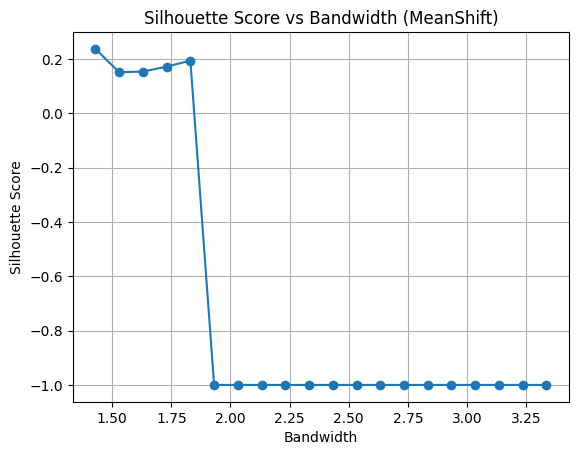

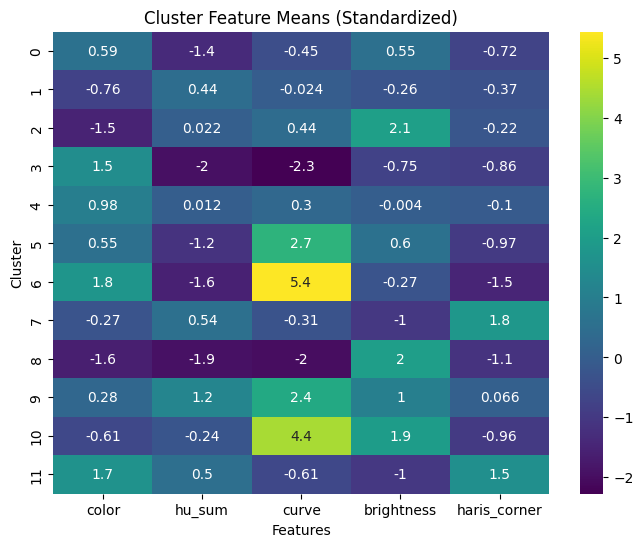

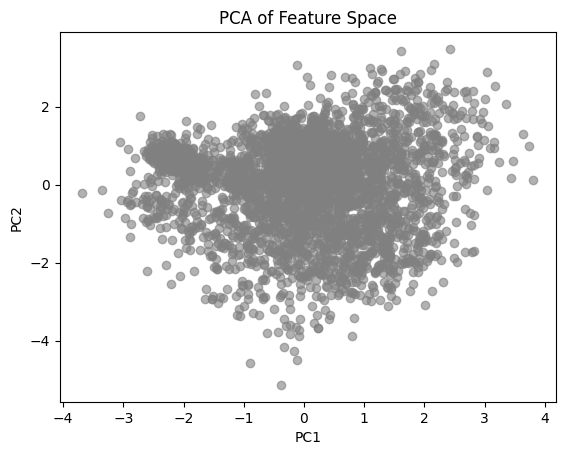

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import estimate_bandwidth

# تابع محاسبه فاصله اقلیدسی
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

# به‌روز رسانی یک نقطه با میانگین نقاط همسایه در داخل bandwidth
def mean_shift_point(x, X, bandwidth):
    # نقاطی که فاصله آن‌ها از x کمتر از bandwidth است
    neighbors = X[np.linalg.norm(X - x, axis=1) <= bandwidth]
    if len(neighbors) > 0:
        return np.mean(neighbors, axis=0)
    else:
        return x

import numpy as np
from scipy.spatial.distance import cdist

def manual_meanshift(X, bandwidth, max_iter=300, tol=1e-3):
    X = np.array(X)
    n_samples, n_features = X.shape
    points = X.copy()
    stop_thresh = tol * bandwidth

    # Initialize centers: one at each point
    centers = X.copy()
    for _ in range(max_iter):
        new_centers = []
        for center in centers:
            # Get all points within bandwidth
            distances = np.linalg.norm(points - center, axis=1)
            in_bandwidth = points[distances < bandwidth]
            if len(in_bandwidth) == 0:
                new_centers.append(center)
                continue
            # Mean of points within bandwidth
            new_center = np.mean(in_bandwidth, axis=0)
            new_centers.append(new_center)
        new_centers = np.array(new_centers)

        # Check for convergence
        shifts = np.linalg.norm(new_centers - centers, axis=1)
        if np.all(shifts < stop_thresh):
            break
        centers = new_centers

    # Remove near-duplicate centers
    unique_centers = []
    for c in centers:
        if all(np.linalg.norm(c - uc) >= bandwidth * 0.5 for uc in unique_centers):
            unique_centers.append(c)
    unique_centers = np.array(unique_centers)

    # Assign points to nearest center
    labels = np.argmin(cdist(X, unique_centers), axis=1)
    return labels



# محاسبه Silhouette Score به صورت دستی
def manual_silhouette_score(X, labels):
    N = len(X)
    # محاسبه ماتریس فاصله
    D = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)
    s = np.zeros(N)
    unique_clusters = np.unique(labels)
    for i in range(N):
        same_mask = (labels == labels[i])
        same_mask[i] = False
        a = np.mean(D[i, same_mask]) if np.any(same_mask) else 0
        b = np.inf
        for cl in unique_clusters:
            if cl == labels[i]:
                continue
            other_mask = (labels == cl)
            if np.any(other_mask):
                avg_dist = np.mean(D[i, other_mask])
                if avg_dist < b:
                    b = avg_dist
        s[i] = 0 if max(a, b) == 0 else (b - a) / max(a, b)
    return np.mean(s)

# پیاده‌سازی tuning برای MeanShift
def meanshift_tuning(X, bandwidth_values):
    best_bandwidth = None
    best_silhouette = -1
    best_labels = None
    sil_scores = []

    for bw in bandwidth_values:
        labels = manual_meanshift(X, bw)
        n_clusters = len(np.unique(labels))

        if n_clusters <= 1 or n_clusters > 50:
            sil = -1
        else:
            sil = manual_silhouette_score(X, labels)

        sil_scores.append(sil)
        print(f"Bandwidth={bw:.3f} → Clusters={n_clusters}, Silhouette={sil:.3f}")

        if sil > best_silhouette:
            best_silhouette = sil
            best_bandwidth = bw
            best_labels = labels

    return best_bandwidth, best_labels, sil_scores

# اجرای tuning و خوشه‌بندی با MeanShift
from sklearn.preprocessing import StandardScaler

def meanshift_clustering_phase():
    df = pd.read_csv("features.csv")
    feature_columns = ['color', 'hu_sum', 'curve', 'brightness', 'haris_corner']
    X = df[feature_columns].values

    X = StandardScaler().fit_transform(X)

    # Estimate a reasonable bandwidth
    base_bw = estimate_bandwidth(X, quantile=0.27, n_samples=500)
    print(f"Estimated base bandwidth: {base_bw:.2f}")

    # Try a tight range around the estimated bandwidth
    bandwidth_values = np.linspace(base_bw * 0.6, base_bw * 1.4, 20)

    best_bw, best_labels, sil_scores = meanshift_tuning(X, bandwidth_values)
    print(f"\n Best bandwidth selected: {best_bw:.2f} with {len(np.unique(best_labels))} clusters.")

    df["cluster"] = best_labels
    df.to_csv("features_with_meanshift_clusters.csv", index=False)

    # Plot silhouette scores
    plt.figure()
    plt.plot(bandwidth_values, sil_scores, marker='o')
    plt.title("Silhouette Score vs Bandwidth (MeanShift)")
    plt.xlabel("Bandwidth")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()

    # Heatmap of cluster means
    clusters = np.unique(best_labels)
    cluster_means = np.array([np.mean(X[best_labels == cl], axis=0) for cl in clusters])
    plt.figure(figsize=(8,6))
    sns.heatmap(cluster_means, annot=True, cmap="viridis", xticklabels=feature_columns)
    plt.title("Cluster Feature Means (Standardized)")
    plt.xlabel("Features")
    plt.ylabel("Cluster")
    plt.show()

    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c='gray', alpha=0.6)
    plt.title("PCA of Feature Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

if __name__ == "__main__":
    meanshift_clustering_phase()


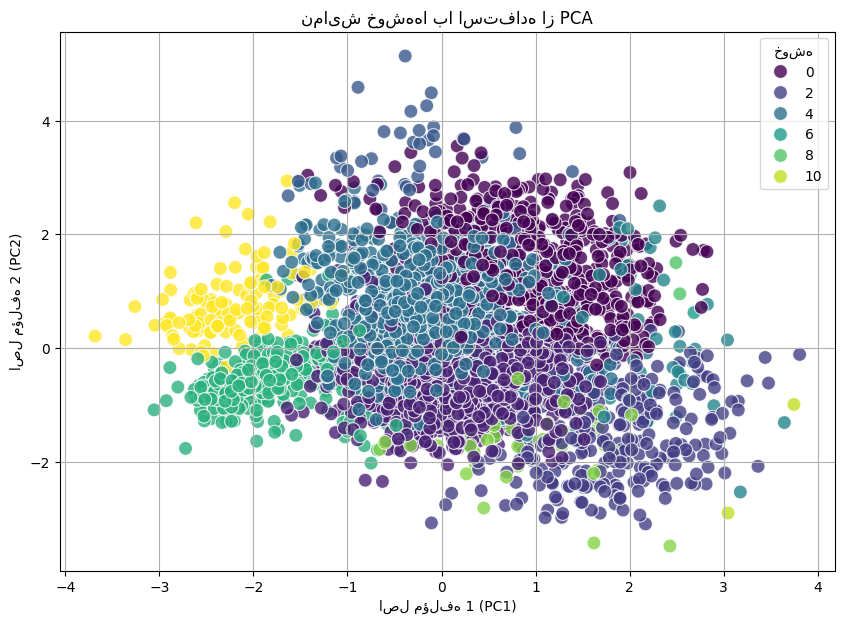

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# بارگذاری داده همراه با برچسب‌های خوشه‌ای (از فایل CSV)
df = pd.read_csv("features_with_meanshift_clusters.csv")
feature_columns = ['color', 'hu_sum', 'curve', 'brightness', 'haris_corner']

# استخراج داده‌ها و نرمال سازی
X = df[feature_columns].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# کاهش ابعاد با PCA به دو بعد
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# افزودن نتایج PCA به دیتافریم
df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

# رسم scatter plot برای خوشه‌ها
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="cluster", palette="viridis", s=100, alpha=0.8)
plt.title("نمایش خوشه‌ها با استفاده از PCA")
plt.xlabel("اصل مؤلفه 1 (PC1)")
plt.ylabel("اصل مؤلفه 2 (PC2)")
plt.legend(title="خوشه")
plt.grid(True)
plt.show()


MEANSHIFT2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

##############################################
# بهینه‌سازی MeanShift: به‌روز رسانی برداری
##############################################
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

def mean_shift_update(shifted_points, X, bandwidth):
    # محاسبه ماتریس فاصله بین تمام نقاط در shifted_points و X
    dists = np.linalg.norm(shifted_points[:, None] - X[None, :], axis=2)
    # ایجاد خروجی جدید با به‌روز رسانی برداری (با حلقه روی سطرها که هزینه نسبتاً کمتری دارد)
    new_points = np.zeros_like(shifted_points)
    for i in range(len(shifted_points)):
        mask = dists[i] <= bandwidth
        if np.any(mask):
            new_points[i] = np.mean(X[mask], axis=0)
        else:
            new_points[i] = shifted_points[i]
    return new_points

def manual_meanshift(X, bandwidth, max_iter=100, tol=1e-3):
    shifted_points = np.copy(X)
    for it in range(max_iter):
        prev_points = shifted_points.copy()
        shifted_points = mean_shift_update(shifted_points, X, bandwidth)
        if np.linalg.norm(shifted_points - prev_points) < tol:
            break
    # اختصاص خوشه: نقاطی که به یکدیگر نزدیکند (فاصله کمتر از bandwidth/2)
    cluster_labels = -np.ones(len(X), dtype=int)
    cluster_id = 0
    for i, point in enumerate(shifted_points):
        if cluster_labels[i] != -1:
            continue
        cluster_labels[i] = cluster_id
        for j in range(i+1, len(shifted_points)):
            if euclidean_distance(point, shifted_points[j]) < bandwidth / 2:
                cluster_labels[j] = cluster_id
        cluster_id += 1
    return cluster_labels

##############################################
# محاسبه Silhouette Score به صورت دستی
##############################################
def manual_silhouette_score(X, labels):
    N = len(X)
    D = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)
    s = np.zeros(N)
    unique_clusters = np.unique(labels)
    for i in range(N):
        same_mask = (labels == labels[i])
        same_mask[i] = False
        a = np.mean(D[i, same_mask]) if np.any(same_mask) else 0
        b = np.inf
        for cl in unique_clusters:
            if cl == labels[i]:
                continue
            other_mask = (labels == cl)
            if np.any(other_mask):
                avg_dist = np.mean(D[i, other_mask])
                if avg_dist < b:
                    b = avg_dist
        s[i] = 0 if max(a, b) == 0 else (b - a) / max(a, b)
    return np.mean(s)

##############################################
# ارزیابی خارجی: محاسبه دستی Precision، Recall و F1-Score
##############################################
def manual_confusion_matrix(true_labels, pred_labels, classes_true, classes_pred):
    cm = np.zeros((len(classes_true), len(classes_pred)), dtype=int)
    for i in range(len(true_labels)):
        t_idx = classes_true.index(true_labels[i])
        p_idx = classes_pred.index(pred_labels[i])
        cm[t_idx, p_idx] += 1
    return cm

def greedy_assignment(cm, classes_true, classes_pred):
    mapping = {}
    cm_copy = cm.copy()
    assigned_true = set()
    assigned_pred = set()
    while np.max(cm_copy) > 0:
        idx = np.unravel_index(np.argmax(cm_copy, axis=None), cm_copy.shape)
        i, j = idx
        if i not in assigned_true and j not in assigned_pred:
            mapping[classes_pred[j]] = classes_true[i]
            assigned_true.add(i)
            assigned_pred.add(j)
        cm_copy[i, j] = 0
    return mapping

def compute_precision_recall_f1(true_labels, mapped_labels, classes):
    precisions, recalls, f1s = [], [], []
    for cl in classes:
        tp = sum((true_labels[i] == cl and mapped_labels[i] == cl) for i in range(len(true_labels)))
        fp = sum((true_labels[i] != cl and mapped_labels[i] == cl) for i in range(len(true_labels)))
        fn = sum((true_labels[i] == cl and mapped_labels[i] != cl) for i in range(len(true_labels)))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

##############################################
# بخش اصلی: Clustering، Visualization و Evaluation برای MeanShift
##############################################
def meanshift_clustering_phase():
    # بارگذاری داده‌های استخراج شده (مثلاً features.csv)
    df = pd.read_csv("features.csv")
    feature_columns = ['color_mean', 'entropy', 'edge_density', 'lbp_mean', 'hu_sum', 'laplacian_var']
    X = df[feature_columns].values

    # تعیین محدوده مقادیر bandwidth برای tuning
    bandwidth_values = np.linspace(1.0, 3.0, 10)
    best_bw = None
    best_silhouette = -1
    best_labels = None
    sil_scores = []
    for bw in bandwidth_values:
        labels = manual_meanshift(X, bw)
        if len(np.unique(labels)) <= 1:
            sil = -1
        else:
            sil = manual_silhouette_score(X, labels)
        sil_scores.append(sil)
        print(f"Bandwidth={bw:.2f}: Silhouette Score={sil:.3f}, Clusters={len(np.unique(labels))}")
        if sil > best_silhouette:
            best_silhouette = sil
            best_bw = bw
            best_labels = labels
    print(f"بهترین bandwidth انتخاب شده: {best_bw:.2f}")

    # ذخیره نتایج خوشه‌بندی در فایل CSV
    df["cluster"] = best_labels
    df.to_csv("features_with_meanshift_clusters.csv", index=False)

    # رسم نمودار Silhouette Score نسبت به bandwidth
    plt.figure()
    plt.plot(bandwidth_values, sil_scores, marker='o')
    plt.title("Silhouette Score vs Bandwidth (MeanShift)")
    plt.xlabel("Bandwidth")
    plt.ylabel("Silhouette Score")
    plt.show()

    # رسم Heatmap میانگین ویژگی‌های هر خوشه
    clusters = np.unique(best_labels)
    cluster_means = np.array([np.mean(X[best_labels == cl], axis=0) for cl in clusters])
    plt.figure(figsize=(8,6))
    sns.heatmap(cluster_means, annot=True, cmap="viridis", xticklabels=feature_columns,
                yticklabels=[f"Cluster {cl}" for cl in clusters])
    plt.title("Heatmap: میانگین ویژگی‌های خوشه‌های MeanShift")
    plt.show()

    # Visualization: کاهش ابعاد با PCA و scatter plot
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8,6))
    for cl in clusters:
        idx = best_labels == cl
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Cluster {cl}", s=50)
    plt.title("Visualization of MeanShift Clusters (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()

    # Evaluation داخلی: محاسبه Silhouette Score
    sil = manual_silhouette_score(X, best_labels)
    print(f"Silhouette Score خوشه‌بندی نهایی: {sil:.3f}")

    # ارزیابی خارجی: محاسبه دستی Precision، Recall و F1-Score (در صورت وجود برچسب‌های واقعی)
    if "class" in df.columns:
        true_labels = df["class"].tolist()
        pred_clusters = df["cluster"].tolist()
        classes_true = sorted(list(set(true_labels)))
        classes_pred = sorted(list(set(pred_clusters)))
        cm = manual_confusion_matrix(true_labels, pred_clusters, classes_true, classes_pred)
        print("ماتریس سردرگمی دستی:")
        print(cm)
        mapping = greedy_assignment(cm, classes_true, classes_pred)
        print("نگاشت خوشه به برچسب واقعی (دستی):")
        print(mapping)
        mapped_labels = [mapping[cl] if cl in mapping else None for cl in pred_clusters]
        macro_prec, macro_rec, macro_f1 = compute_precision_recall_f1(true_labels, mapped_labels, classes_true)
        print(f"Precision (دستی): {macro_prec:.3f}")
        print(f"Recall (دستی): {macro_rec:.3f}")
        print(f"F1-Score (دستی): {macro_f1:.3f}")

if __name__ == "__main__":
    meanshift_clustering_phase()


Bandwidth=1.00: Silhouette Score=1.000, Clusters=3599


MEANSHIFT3

Bandwidth تخمینی: 2211.18
Silhouette Score خوشه‌بندی: 0.565


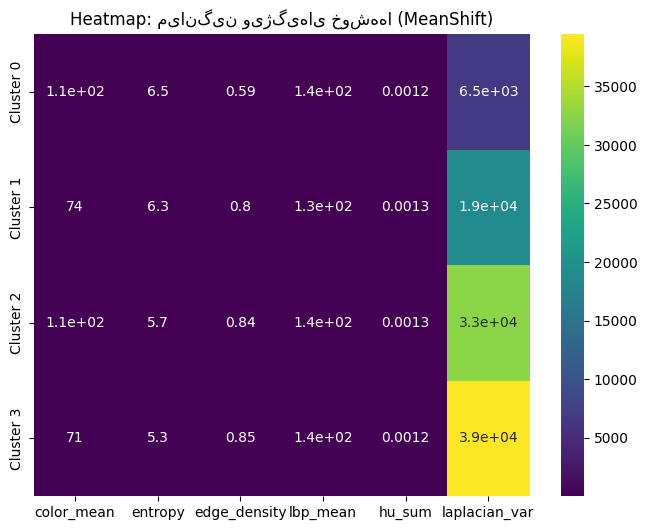

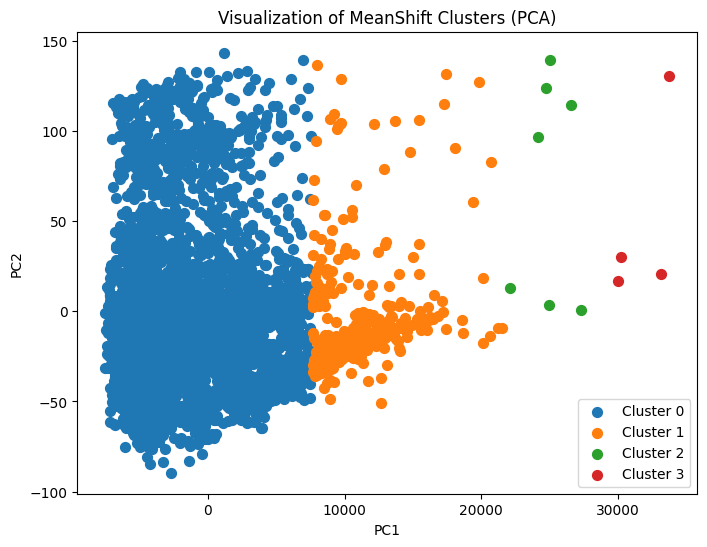

ماتریس سردرگمی اولیه:
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
نگاشت خوشه به برچسب واقعی:
{'beach': '0', 'dense_residential': '1', 'desert': '2', 'sea_ice': '3', '0': 'beach', 'forest': 'dense_residential', '2': 'desert', '1': 'forest', 'intersection': 'intersection', '3': 'sea_ice'}
Precision (دستی با توابع آماده): 0.283
Recall (دستی با توابع آماده): 0.214
F1-Score (دستی با توابع آماده): 0.119


C:\Users\ASUS\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

# بارگذاری داده‌های استخراج شده (features.csv)
df = pd.read_csv("features.csv")
feature_columns = ['color_mean', 'entropy', 'edge_density', 'lbp_mean', 'hu_sum', 'laplacian_var']
X = df[feature_columns].values

# تعیین bandwidth به صورت خودکار
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=len(X))
print(f"Bandwidth تخمینی: {bandwidth:.2f}")

# اجرای خوشه‌بندی MeanShift با پارامترهای بهینه
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_labels = ms.fit_predict(X)
df["cluster"] = ms_labels

# محاسبه Silhouette Score داخلی
sil_score = silhouette_score(X, ms_labels)
print(f"Silhouette Score خوشه‌بندی: {sil_score:.3f}")

# رسم Heatmap میانگین ویژگی‌های هر خوشه
clusters = np.unique(ms_labels)
cluster_means = np.array([np.mean(X[ms_labels == cl], axis=0) for cl in clusters])
plt.figure(figsize=(8,6))
sns.heatmap(cluster_means, annot=True, cmap="viridis", 
            xticklabels=feature_columns,
            yticklabels=[f"Cluster {cl}" for cl in clusters])
plt.title("Heatmap: میانگین ویژگی‌های خوشه‌ها (MeanShift)")
plt.show()

# Visualization: کاهش ابعاد با PCA و scatter plot
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8,6))
for cl in clusters:
    idx = ms_labels == cl
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Cluster {cl}", s=50)
plt.title("Visualization of MeanShift Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# ارزیابی خارجی: در صورت وجود برچسب‌های واقعی (ستون "class")
if "class" in df.columns:
    true_labels = df["class"].tolist()
    pred_labels = ms_labels.tolist()
    
    # محاسبه ماتریس سردرگمی
    classes_true = sorted(list(set(true_labels)))
    classes_pred = sorted(list(set(pred_labels)))
    cm = confusion_matrix(true_labels, pred_labels, labels=classes_true)
    print("ماتریس سردرگمی اولیه:")
    print(cm)
    
    # نگاشت خوشه به برچسب واقعی با الگوریتم Hungarian
    # برای این کار از -cm (منفی ماتریس) استفاده می‌کنیم تا بیشینه تطابق را پیدا کنیم.
    true_labels = [str(label) for label in df["class"].tolist()]  # تبدیل به رشته
    pred_labels = [str(label) for label in ms_labels.tolist()]  # تبدیل به رشته
    all_labels = sorted(list(set(true_labels) | set(pred_labels)))  # حل مشکل مرتب‌سازی
    # all_labels = sorted(list(set(true_labels) | set(pred_labels)))
    cm = confusion_matrix(true_labels, pred_labels, labels=all_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {all_labels[j]: all_labels[i] for i, j in zip(row_ind, col_ind)}

    # row_ind, col_ind = linear_sum_assignment(-cm)
    # mapping = {classes_pred[j]: classes_true[i] for i, j in zip(row_ind, col_ind)}
    print("نگاشت خوشه به برچسب واقعی:")
    print(mapping)
    
    # اعمال نگاشت روی برچسب‌های پیش‌بینی شده
    mapped_labels = [mapping[label] if label in mapping else None for label in pred_labels]
    
    # محاسبه Precision، Recall و F1-Score به صورت macro-averaged
    prec = precision_score(true_labels, mapped_labels, average="macro")
    rec = recall_score(true_labels, mapped_labels, average="macro")
    f1 = f1_score(true_labels, mapped_labels, average="macro")
    print(f"Precision (دستی با توابع آماده): {prec:.3f}")
    print(f"Recall (دستی با توابع آماده): {rec:.3f}")
    print(f"F1-Score (دستی با توابع آماده): {f1:.3f}")


DBSCAN بهینه نیست

New best: eps=0.529, min_samples=8
Silhouette: -0.102, Davies-Bouldin: 1.808
Clusters: 18, Noise: 37.3%

New best: eps=0.529, min_samples=9
Silhouette: -0.090, Davies-Bouldin: 1.688
Clusters: 17, Noise: 41.4%

New best: eps=0.625, min_samples=5
Silhouette: 0.023, Davies-Bouldin: 2.352
Clusters: 17, Noise: 13.1%

New best: eps=0.722, min_samples=4
Silhouette: 0.111, Davies-Bouldin: 2.850
Clusters: 5, Noise: 6.0%

New best: eps=0.915, min_samples=3
Silhouette: 0.211, Davies-Bouldin: 2.924
Clusters: 3, Noise: 1.2%

New best: eps=1.012, min_samples=2
Silhouette: 0.164, Davies-Bouldin: 2.130
Clusters: 5, Noise: 0.6%

New best: eps=1.012, min_samples=3
Silhouette: 0.240, Davies-Bouldin: 2.106
Clusters: 3, Noise: 0.7%

New best: eps=1.108, min_samples=3
Silhouette: 0.287, Davies-Bouldin: 2.503
Clusters: 2, Noise: 0.5%

New best: eps=1.205, min_samples=2
Silhouette: 0.372, Davies-Bouldin: 2.573
Clusters: 2, Noise: 0.3%

New best: eps=1.205, min_samples=3
Silhouette: 0.408, Davies-Bouldin: 2.63

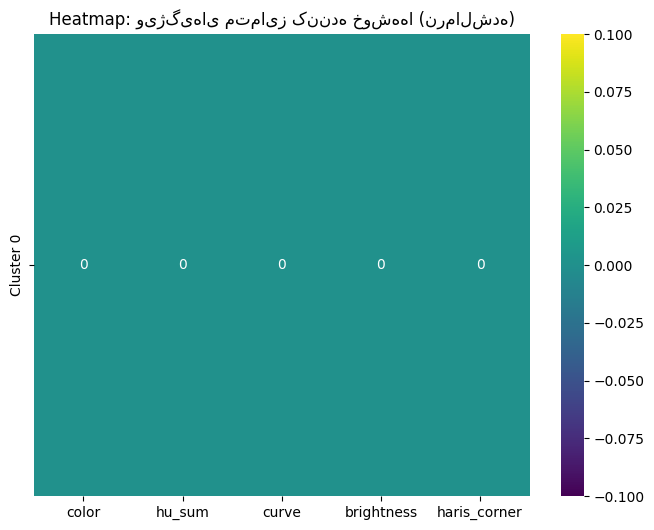

C:\Users\AsiaLapTop.Com\AppData\Local\Temp\ipykernel_2980\2101305059.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_names, y=cluster_sizes, palette='viridis')


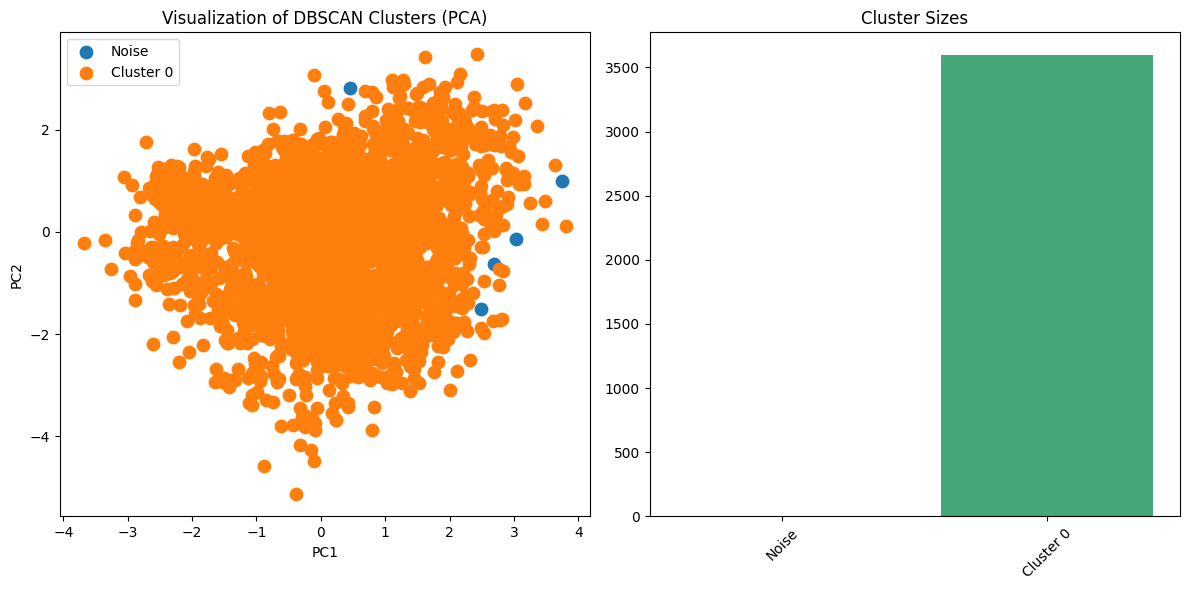

Confusion Matrix:
[[  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  3 597   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0]
 [  3 597   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0]]
Mapping (predicted -> true):
{'dense_residential': '-1', 'beach': '0', '-1': 'beach', '0': 'dense_residential', 'desert': 'desert', 'forest': 'forest', 'intersection': 'intersection', 'sea_ice': 'sea_ice'}
Precision: 0.111
Recall: 0.168
F1-Score: 0.049
Noise ratio: 0.17%


C:\Users\AsiaLapTop.Com\CI_MidProject\environment\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# بارگذاری و پیش‌پردازش داده‌ها
df = pd.read_csv("features.csv")
feature_columns = ['color', 'hu_sum', 'curve', 'brightness', 'haris_corner']

# نرمالسازی داده‌ها
scaler = StandardScaler()
X = scaler.fit_transform(df[feature_columns].values)

# تعیین محدوده eps با استفاده از تحلیل k-distance
def find_eps_threshold(X, k=5, percentile=90):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    k_distances = distances[:, -1]
    return np.percentile(k_distances, percentile)

# محاسبه خودکار محدوده eps
k = 5  # min_samples پیش‌فرض
eps_estimate = find_eps_threshold(X, k=k)
eps_values = np.linspace(eps_estimate*0.3, eps_estimate*2, 15)

# گسترش محدوده min_samples
min_samples_values = list(range(2, 12))

best_score = -1
best_params = None
best_labels = None
best_n_clusters = 0

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)
        
        # فیلتر کردن حالات نامطلوب
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # شرط‌های پذیرش
        if n_clusters < 1 or n_clusters > 20:
            continue
        if n_noise > 0.5 * len(X):  # نویز بیش از 50% داده
            continue
            
        try:
            sil_score = silhouette_score(X, labels)
            db_score = davies_bouldin_score(X, labels)
            combined_score = sil_score - (db_score/10)  # ترکیب معیارها
        except:
            continue
            
        # به روزرسانی بهترین پارامترها
        if combined_score > best_score:
            best_score = combined_score
            best_params = (eps, min_samples)
            best_labels = labels
            best_n_clusters = n_clusters

            print(f"New best: eps={eps:.3f}, min_samples={min_samples}")
            print(f"Silhouette: {sil_score:.3f}, Davies-Bouldin: {db_score:.3f}")
            print(f"Clusters: {n_clusters}, Noise: {n_noise/len(X):.1%}\n")

if best_params is None:
    print("هیچ ترکیب مناسبی برای DBSCAN پیدا نشد.")
else:
    print(f"\nبهترین پارامترها: eps={best_params[0]:.3f}, min_samples={best_params[1]}")
    print(f"تعداد خوشه‌ها: {best_n_clusters}")
    final_sil = silhouette_score(X, best_labels)
    print(f"Silhouette Score: {final_sil:.3f}")
    
    df["cluster"] = best_labels
    df.to_csv("features_with_dbscan_clusters.csv", index=False)
    
    # رسم Heatmap میانگین ویژگی‌های خوشه‌ها (عدم نمایش نویز)
    valid_clusters = [cl for cl in np.unique(best_labels) if cl != -1]
    cluster_means = np.array([np.mean(X[best_labels == cl], axis=0) for cl in valid_clusters])
    # نرمال‌سازی میانگین‌ها برای نمایش بهتر (تبدیل هر ستون به مقیاس 0 تا 1)
    cluster_means_norm = (cluster_means - cluster_means.min(axis=0)) / (np.ptp(cluster_means, axis=0) + 1e-6)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cluster_means_norm, annot=True, cmap="viridis", 
                xticklabels=feature_columns,
                yticklabels=[f"Cluster {cl}" for cl in valid_clusters])
    plt.title("Heatmap: ویژگی‌های متمایز کننده خوشه‌ها (نرمال‌شده)")
    plt.show()
    
    # Visualization: کاهش ابعاد با PCA و رسم scatter plot
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for cl in np.unique(best_labels):
        idx = best_labels == cl
        label_name = f"Cluster {cl}" if cl != -1 else "Noise"
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label_name, s=80)
    plt.title("Visualization of DBSCAN Clusters (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    
    # رسم نمودار میله‌ای اندازه خوشه‌ها
    plt.subplot(1, 2, 2)
    unique_labels = np.unique(best_labels)
    cluster_sizes = [np.sum(best_labels == cl) for cl in unique_labels]
    labels_names = [f'Cluster {cl}' if cl != -1 else 'Noise' for cl in unique_labels]
    sns.barplot(x=labels_names, y=cluster_sizes, palette='viridis')
    plt.title("Cluster Sizes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # ارزیابی خارجی: در صورت موجود بودن برچسب‌های واقعی (ستون "class")
    if "class" in df.columns:
        true_labels = df["class"].astype(str).tolist()
        pred_labels = [str(label) for label in best_labels.tolist()]
        all_labels = sorted(list(set(true_labels) | set(pred_labels)))
        cm = confusion_matrix(true_labels, pred_labels, labels=all_labels)
        print("Confusion Matrix:")
        print(cm)
        
        row_ind, col_ind = linear_sum_assignment(-cm)
        mapping = {all_labels[col]: all_labels[row] for row, col in zip(row_ind, col_ind)}
        print("Mapping (predicted -> true):")
        print(mapping)
        
        mapped_labels = [mapping[label] if label in mapping else label for label in pred_labels]
        macro_prec = precision_score(true_labels, mapped_labels, average='weighted')
        macro_rec = recall_score(true_labels, mapped_labels, average='weighted')
        macro_f1 = f1_score(true_labels, mapped_labels, average='weighted')
        print(f"Precision: {macro_prec:.3f}")
        print(f"Recall: {macro_rec:.3f}")
        print(f"F1-Score: {macro_f1:.3f}")

noise_ratio = np.sum(best_labels == -1) / len(best_labels)
print(f"Noise ratio: {noise_ratio:.2%}")


AGGLOMORATIVE

Distribution of clusters: {np.int64(0): np.int64(1066), np.int64(1): np.int64(959), np.int64(2): np.int64(359), np.int64(3): np.int64(675), np.int64(4): np.int64(241), np.int64(5): np.int64(300)}


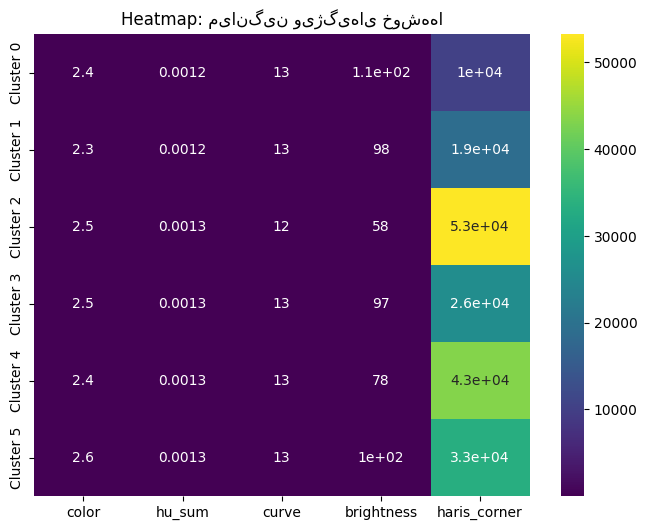

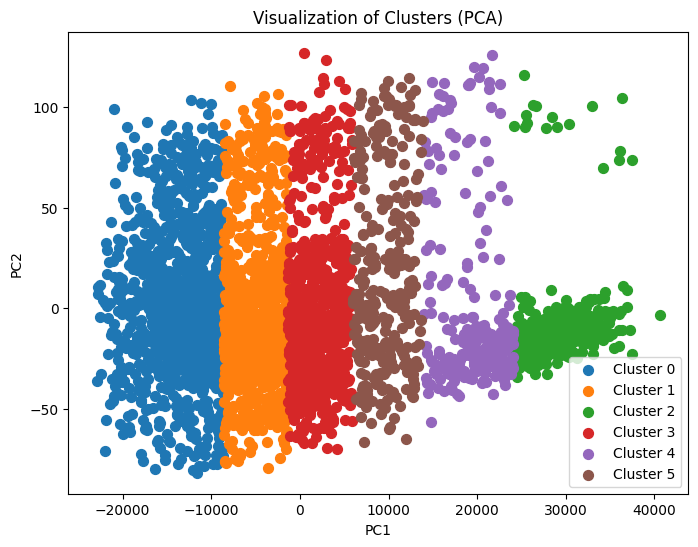

Final Silhouette Score: 0.531
Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [411 116   0  52   0  21   0   0   0   0   0   0]
 [ 31 304   0 197  17  51   0   0   0   0   0   0]
 [165 139  17 135  45  99   0   0   0   0   0   0]
 [  0  16 341  44 160  39   0   0   0   0   0   0]
 [358 207   0  34   0   1   0   0   0   0   0   0]
 [101 177   1 213  19  89   0   0   0   0   0   0]]
Mapping (predicted -> true): {'beach': '0', 'dense_residential': '1', 'forest': '2', 'desert': '3', '4': '4', 'intersection': '5', '0': 'beach', '1': 'dense_residential', '5': 'desert', '2': 'forest', 'sea_ice': 'intersection', '3': 'sea_ice'}
Precision: 0.328
Recall: 0.326
F1-Score: 0.307


C:\Users\AsiaLapTop.Com\CI_MidProject\environment\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AsiaLapTop.Com\CI_MidProject\environment\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

# بارگذاری داده‌ها
df = pd.read_csv("features.csv")
feature_columns = ['color', 'hu_sum', 'curve', 'brightness', 'haris_corner']
X = df[feature_columns].values

# تنظیم تعداد خوشه مورد نظر (به عنوان مثال 6)
n_clusters_desired = 6
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters_desired, linkage="ward")
labels = agg_clustering.fit_predict(X)

# چاپ توزیع خوشه‌ها
unique_labels, counts = np.unique(labels, return_counts=True)
print("Distribution of clusters:", dict(zip(unique_labels, counts)))

df["cluster"] = labels
df.to_csv("features_with_clusters_Agglomorative.csv", index=False)

# رسم Heatmap میانگین ویژگی‌های هر خوشه
cluster_means = np.array([np.mean(X[labels == cl], axis=0) for cl in range(n_clusters_desired)])
plt.figure(figsize=(8,6))
sns.heatmap(cluster_means, annot=True, cmap="viridis", xticklabels=feature_columns,
            yticklabels=[f"Cluster {cl}" for cl in range(n_clusters_desired)])
plt.title("Heatmap: میانگین ویژگی‌های خوشه‌ها")
plt.show()

# Visualization: کاهش ابعاد با PCA و رسم scatter plot
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8,6))
for cl in range(n_clusters_desired):
    idx = labels == cl
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Cluster {cl}", s=50)
plt.title("Visualization of Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# ارزیابی داخلی: Silhouette Score نهایی
final_sil = silhouette_score(X, labels)
print(f"Final Silhouette Score: {final_sil:.3f}")

# ارزیابی خارجی: در صورت موجود بودن برچسب‌های واقعی (ستون "class")
if "class" in df.columns:
    true_labels = df["class"].astype(str).tolist()
    pred_labels = [str(label) for label in labels]
    all_labels = sorted(list(set(true_labels) | set(pred_labels)))
    cm = confusion_matrix(true_labels, pred_labels, labels=all_labels)
    print("Confusion Matrix:")
    print(cm)
    
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {all_labels[col]: all_labels[row] for row, col in zip(row_ind, col_ind)}
    print("Mapping (predicted -> true):", mapping)
    
    mapped_labels = [mapping[label] if label in mapping else label for label in pred_labels]
    macro_prec = precision_score(true_labels, mapped_labels, average="macro")
    macro_rec = recall_score(true_labels, mapped_labels, average="macro")
    macro_f1 = f1_score(true_labels, mapped_labels, average="macro")
    print(f"Precision: {macro_prec:.3f}")
    print(f"Recall: {macro_rec:.3f}")
    print(f"F1-Score: {macro_f1:.3f}")


n_clusters = 2 --> Silhouette Score: 0.676
n_clusters = 3 --> Silhouette Score: 0.563
n_clusters = 4 --> Silhouette Score: 0.533
n_clusters = 5 --> Silhouette Score: 0.507
n_clusters = 6 --> Silhouette Score: 0.531
n_clusters = 7 --> Silhouette Score: 0.520
n_clusters = 8 --> Silhouette Score: 0.518
n_clusters = 9 --> Silhouette Score: 0.512
n_clusters = 10 --> Silhouette Score: 0.514
n_clusters = 11 --> Silhouette Score: 0.508
n_clusters = 12 --> Silhouette Score: 0.504
n_clusters = 13 --> Silhouette Score: 0.507
n_clusters = 14 --> Silhouette Score: 0.517
n_clusters = 15 --> Silhouette Score: 0.520

بهترین تعداد خوشه: 2 با Silhouette Score = 0.676


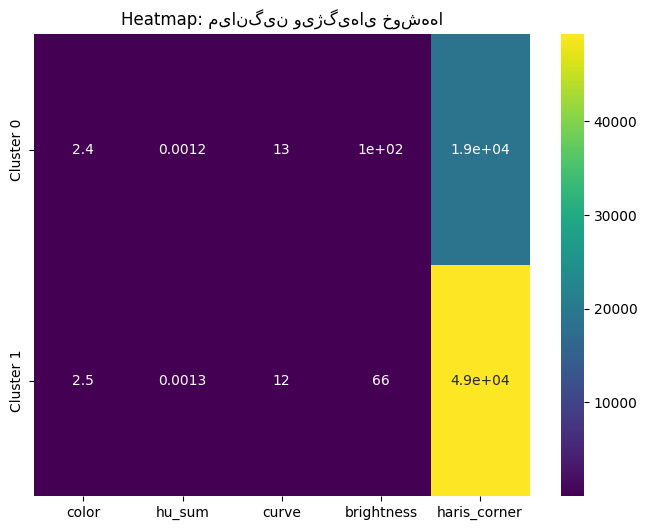

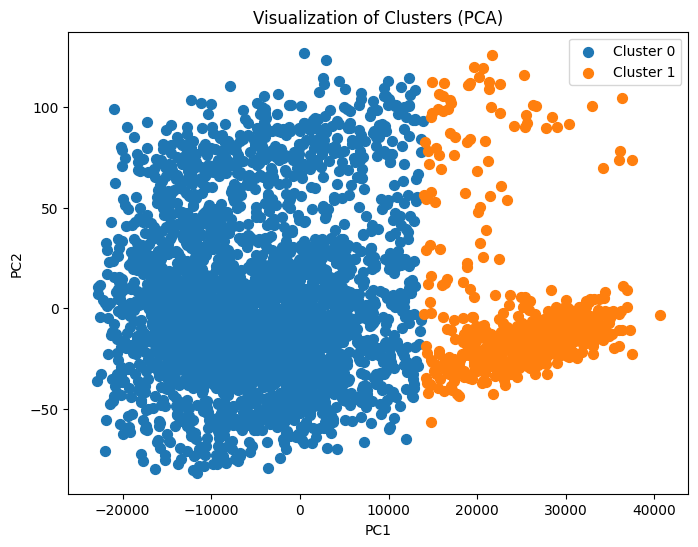

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# بارگذاری داده‌ها
df = pd.read_csv("features.csv")
feature_columns = ['color', 'hu_sum', 'curve', 'brightness', 'haris_corner']
X = df[feature_columns].values

# تعریف محدوده تعداد خوشه‌ها برای tuning
cluster_range = range(2, 16)  # از 2 تا 15 خوشه

best_score = -1
best_n_clusters = None
best_labels = None

# حلقه برای تست تعداد مختلف خوشه‌ها
for n_clusters in cluster_range:
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    labels = model.fit_predict(X)
    
    # محاسبه Silhouette Score
    if len(np.unique(labels)) > 1:  # در صورتی که بیش از یک خوشه تشکیل شده باشد
        score = silhouette_score(X, labels)
        print(f"n_clusters = {n_clusters} --> Silhouette Score: {score:.3f}")
        
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters
            best_labels = labels

# چاپ بهترین نتیجه
print(f"\nبهترین تعداد خوشه: {best_n_clusters} با Silhouette Score = {best_score:.3f}")

# ذخیره نتایج خوشه‌بندی به فایل CSV
df["cluster"] = best_labels
df.to_csv("features_with_clusters_Agglomerative_tuned.csv", index=False)

# رسم Heatmap میانگین ویژگی‌های هر خوشه
cluster_means = np.array([np.mean(X[best_labels == cl], axis=0) for cl in range(best_n_clusters)])
plt.figure(figsize=(8,6))
sns.heatmap(cluster_means, annot=True, cmap="viridis", xticklabels=feature_columns,
            yticklabels=[f"Cluster {cl}" for cl in range(best_n_clusters)])
plt.title("Heatmap: میانگین ویژگی‌های خوشه‌ها")
plt.show()

# Visualization: کاهش ابعاد با PCA و رسم scatter plot
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8,6))
for cl in range(best_n_clusters):
    idx = best_labels == cl
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Cluster {cl}", s=50)
plt.title("Visualization of Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


AGGLOMORATIVE2

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, confusion_matrix, precision_score, recall_score, f1_score
from scipy.optimize import linear_sum_assignment

##############################################
# پیاده‌سازی دستی Agglomerative Clustering (Single Linkage)
##############################################
def manual_agglomerative_clustering(X, k):
    # ابتدا هر نمونه به عنوان یک خوشه جداگانه
    clusters = [[i] for i in range(len(X))]
    
    # ادامه ادغام تا رسیدن به تعداد خوشه‌های k
    while len(clusters) > k:
        min_dist = np.inf
        merge_pair = None
        # برای هر دو خوشه بررسی فاصله کمینه (Single Linkage)
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                # فاصله بین دو خوشه، کمترین فاصله بین هر دو نقطه از آن‌ها
                dist_ij = np.inf
                for idx1 in clusters[i]:
                    for idx2 in clusters[j]:
                        d = np.linalg.norm(X[idx1] - X[idx2])
                        if d < dist_ij:
                            dist_ij = d
                if dist_ij < min_dist:
                    min_dist = dist_ij
                    merge_pair = (i, j)
        # ادغام خوشه‌ها
        i, j = merge_pair
        clusters[i] = clusters[i] + clusters[j]
        del clusters[j]
    
    # ایجاد برچسب برای هر نمونه بر اساس خوشه‌های نهایی
    labels = np.empty(len(X), dtype=int)
    for cluster_id, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = cluster_id
    return labels

##############################################
# Evaluation خارجی: همان بخش قبلی
##############################################
def manual_confusion_matrix(true_labels, pred_labels, classes_true, classes_pred):
    cm = np.zeros((len(classes_true), len(classes_pred)), dtype=int)
    for i in range(len(true_labels)):
        t_idx = classes_true.index(true_labels[i])
        p_idx = classes_pred.index(pred_labels[i])
        cm[t_idx, p_idx] += 1
    return cm

def greedy_assignment(cm, classes_true, classes_pred):
    mapping = {}
    cm_copy = cm.copy()
    assigned_true = set()
    assigned_pred = set()
    while np.max(cm_copy) > 0:
        idx = np.unravel_index(np.argmax(cm_copy, axis=None), cm_copy.shape)
        i, j = idx  # i: اندیس کلاس واقعی، j: اندیس خوشه
        if i not in assigned_true and j not in assigned_pred:
            mapping[classes_pred[j]] = classes_true[i]
            assigned_true.add(i)
            assigned_pred.add(j)
        cm_copy[i, j] = 0
    return mapping

def compute_precision_recall_f1(true_labels, mapped_labels, classes):
    precisions, recalls, f1s = [], [], []
    for cl in classes:
        tp = sum((true_labels[i]==cl and mapped_labels[i]==cl) for i in range(len(true_labels)))
        fp = sum((true_labels[i]!=cl and mapped_labels[i]==cl) for i in range(len(true_labels)))
        fn = sum((true_labels[i]==cl and mapped_labels[i]!=cl) for i in range(len(true_labels)))
        prec = tp/(tp+fp) if (tp+fp)>0 else 0
        rec = tp/(tp+fn) if (tp+fn)>0 else 0
        f1 = (2*prec*rec/(prec+rec)) if (prec+rec)>0 else 0
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

##############################################
# Clustering، Visualization و Evaluation (با استفاده از پیاده‌سازی دستی Agglomerative)
##############################################
def clustering_phase_manual():
    # بارگذاری داده‌ها
    df = pd.read_csv("features.csv")
    feature_columns = ['color', 'hu_sum', 'curve', 'brightness', 'haris_corner']
    X = df[feature_columns].values

    # تست تعداد خوشه‌های مختلف با پیاده‌سازی دستی
    cluster_range = range(2, 11)
    best_sil = -1
    best_n_clusters = None
    best_labels = None

    for n_clusters in cluster_range:
        labels = manual_agglomerative_clustering(X, n_clusters)
        # در صورتی که تعداد خوشه‌ها کمتر از 2 شود، نادیده می‌گیریم
        if len(np.unique(labels)) < 2:
            continue
        sil = silhouette_score(X, labels)
        print(f"n_clusters={n_clusters}: Silhouette Score={sil:.3f}")
        if sil > best_sil:
            best_sil = sil
            best_n_clusters = n_clusters
            best_labels = labels

    print(f"\nبهترین تعداد خوشه‌ها: {best_n_clusters} با Silhouette Score={best_sil:.3f}")
    df["cluster"] = best_labels
    df.to_csv("features_with_manual_agglomerative_clusters.csv", index=False)

    # رسم Heatmap میانگین ویژگی‌های هر خوشه
    cluster_means = np.array([np.mean(X[best_labels == cl], axis=0) for cl in range(best_n_clusters)])
    plt.figure(figsize=(8,6))
    sns.heatmap(cluster_means, annot=True, cmap="viridis", xticklabels=feature_columns,
                yticklabels=[f"Cluster {cl}" for cl in range(best_n_clusters)])
    plt.title("Heatmap: میانگین ویژگی‌های خوشه‌ها (Manual Agglomerative)")
    plt.show()

    # Visualization: کاهش ابعاد با PCA
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8,6))
    for cl in range(best_n_clusters):
        idx = best_labels == cl
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Cluster {cl}", s=50)
    plt.title("Visualization of Clusters (PCA) - Manual Agglomerative")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()

    # ارزیابی داخلی: Silhouette Score نهایی
    final_sil = silhouette_score(X, best_labels)
    print(f"Final Silhouette Score: {final_sil:.3f}")

    # ارزیابی خارجی: در صورت موجود بودن برچسب‌های واقعی (ستون "class")
    if "class" in df.columns:
        true_labels = df["class"].astype(str).tolist()
        pred_labels = [str(label) for label in best_labels]
        all_labels = sorted(list(set(true_labels) | set(pred_labels)))
        cm = confusion_matrix(true_labels, pred_labels, labels=all_labels)
        print("Confusion Matrix:")
        print(cm)
        row_ind, col_ind = linear_sum_assignment(-cm)
        mapping = {all_labels[col]: all_labels[row] for row, col in zip(row_ind, col_ind)}
        print("Mapping (predicted -> true):", mapping)
        mapped_labels = [mapping[label] if label in mapping else label for label in pred_labels]
        macro_prec, macro_rec, macro_f1 = compute_precision_recall_f1(true_labels, mapped_labels, all_labels)
        print(f"Precision: {macro_prec:.3f}")
        print(f"Recall: {macro_rec:.3f}")
        print(f"F1-Score: {macro_f1:.3f}")

if __name__ == "__main__":
    clustering_phase_manual()


KeyboardInterrupt: 

PHASE6

In [20]:
import pandas as pd
import numpy as np

# Load the training data with clusters
train_df = pd.read_csv('features_with_clusters.csv')
selected_features = ['color', 'hu_sum', 'curve', 'brightness', 'haris_corner']

# Extract training features and labels
X_train = train_df[selected_features].values
train_labels = train_df['cluster'].values
k = len(np.unique(train_labels))

# Compute centroids from the training data
def compute_centroids(X, labels, k):
    centroids = []
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroids.append(np.mean(cluster_points, axis=0))
        else:
            centroids.append(np.zeros(X.shape[1]))
    return np.array(centroids)

centroids = compute_centroids(X_train, train_labels, k)

# Load test features (you should have a CSV for these too)
process_dataset("test", output_csv="test_features.csv")
test_df = pd.read_csv('test_features.csv')  # replace with your actual file name
X_test = test_df[selected_features].values

# Assign clusters to test data using trained centroids
def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
    return np.argmin(distances, axis=1)

test_df['cluster'] = assign_clusters(X_test, centroids)

# Optional: Map clusters to labels
cluster_to_label = {
    0: 'intersection',
    1: 'forest',
    2: 'beach',
    3: 'desert',
    4: 'dense_residential',
    5: 'sea_ice'
}

test_df['label'] = test_df['cluster'].map(cluster_to_label)

# Save results
test_df.to_csv('test_with_clusters.csv', index=False)
print("Test clustering completed and saved to 'test_with_clusters.csv'")


ویژگی‌ها در فایل test_features.csv ذخیره شدند.
Test clustering completed and saved to 'test_with_clusters.csv'


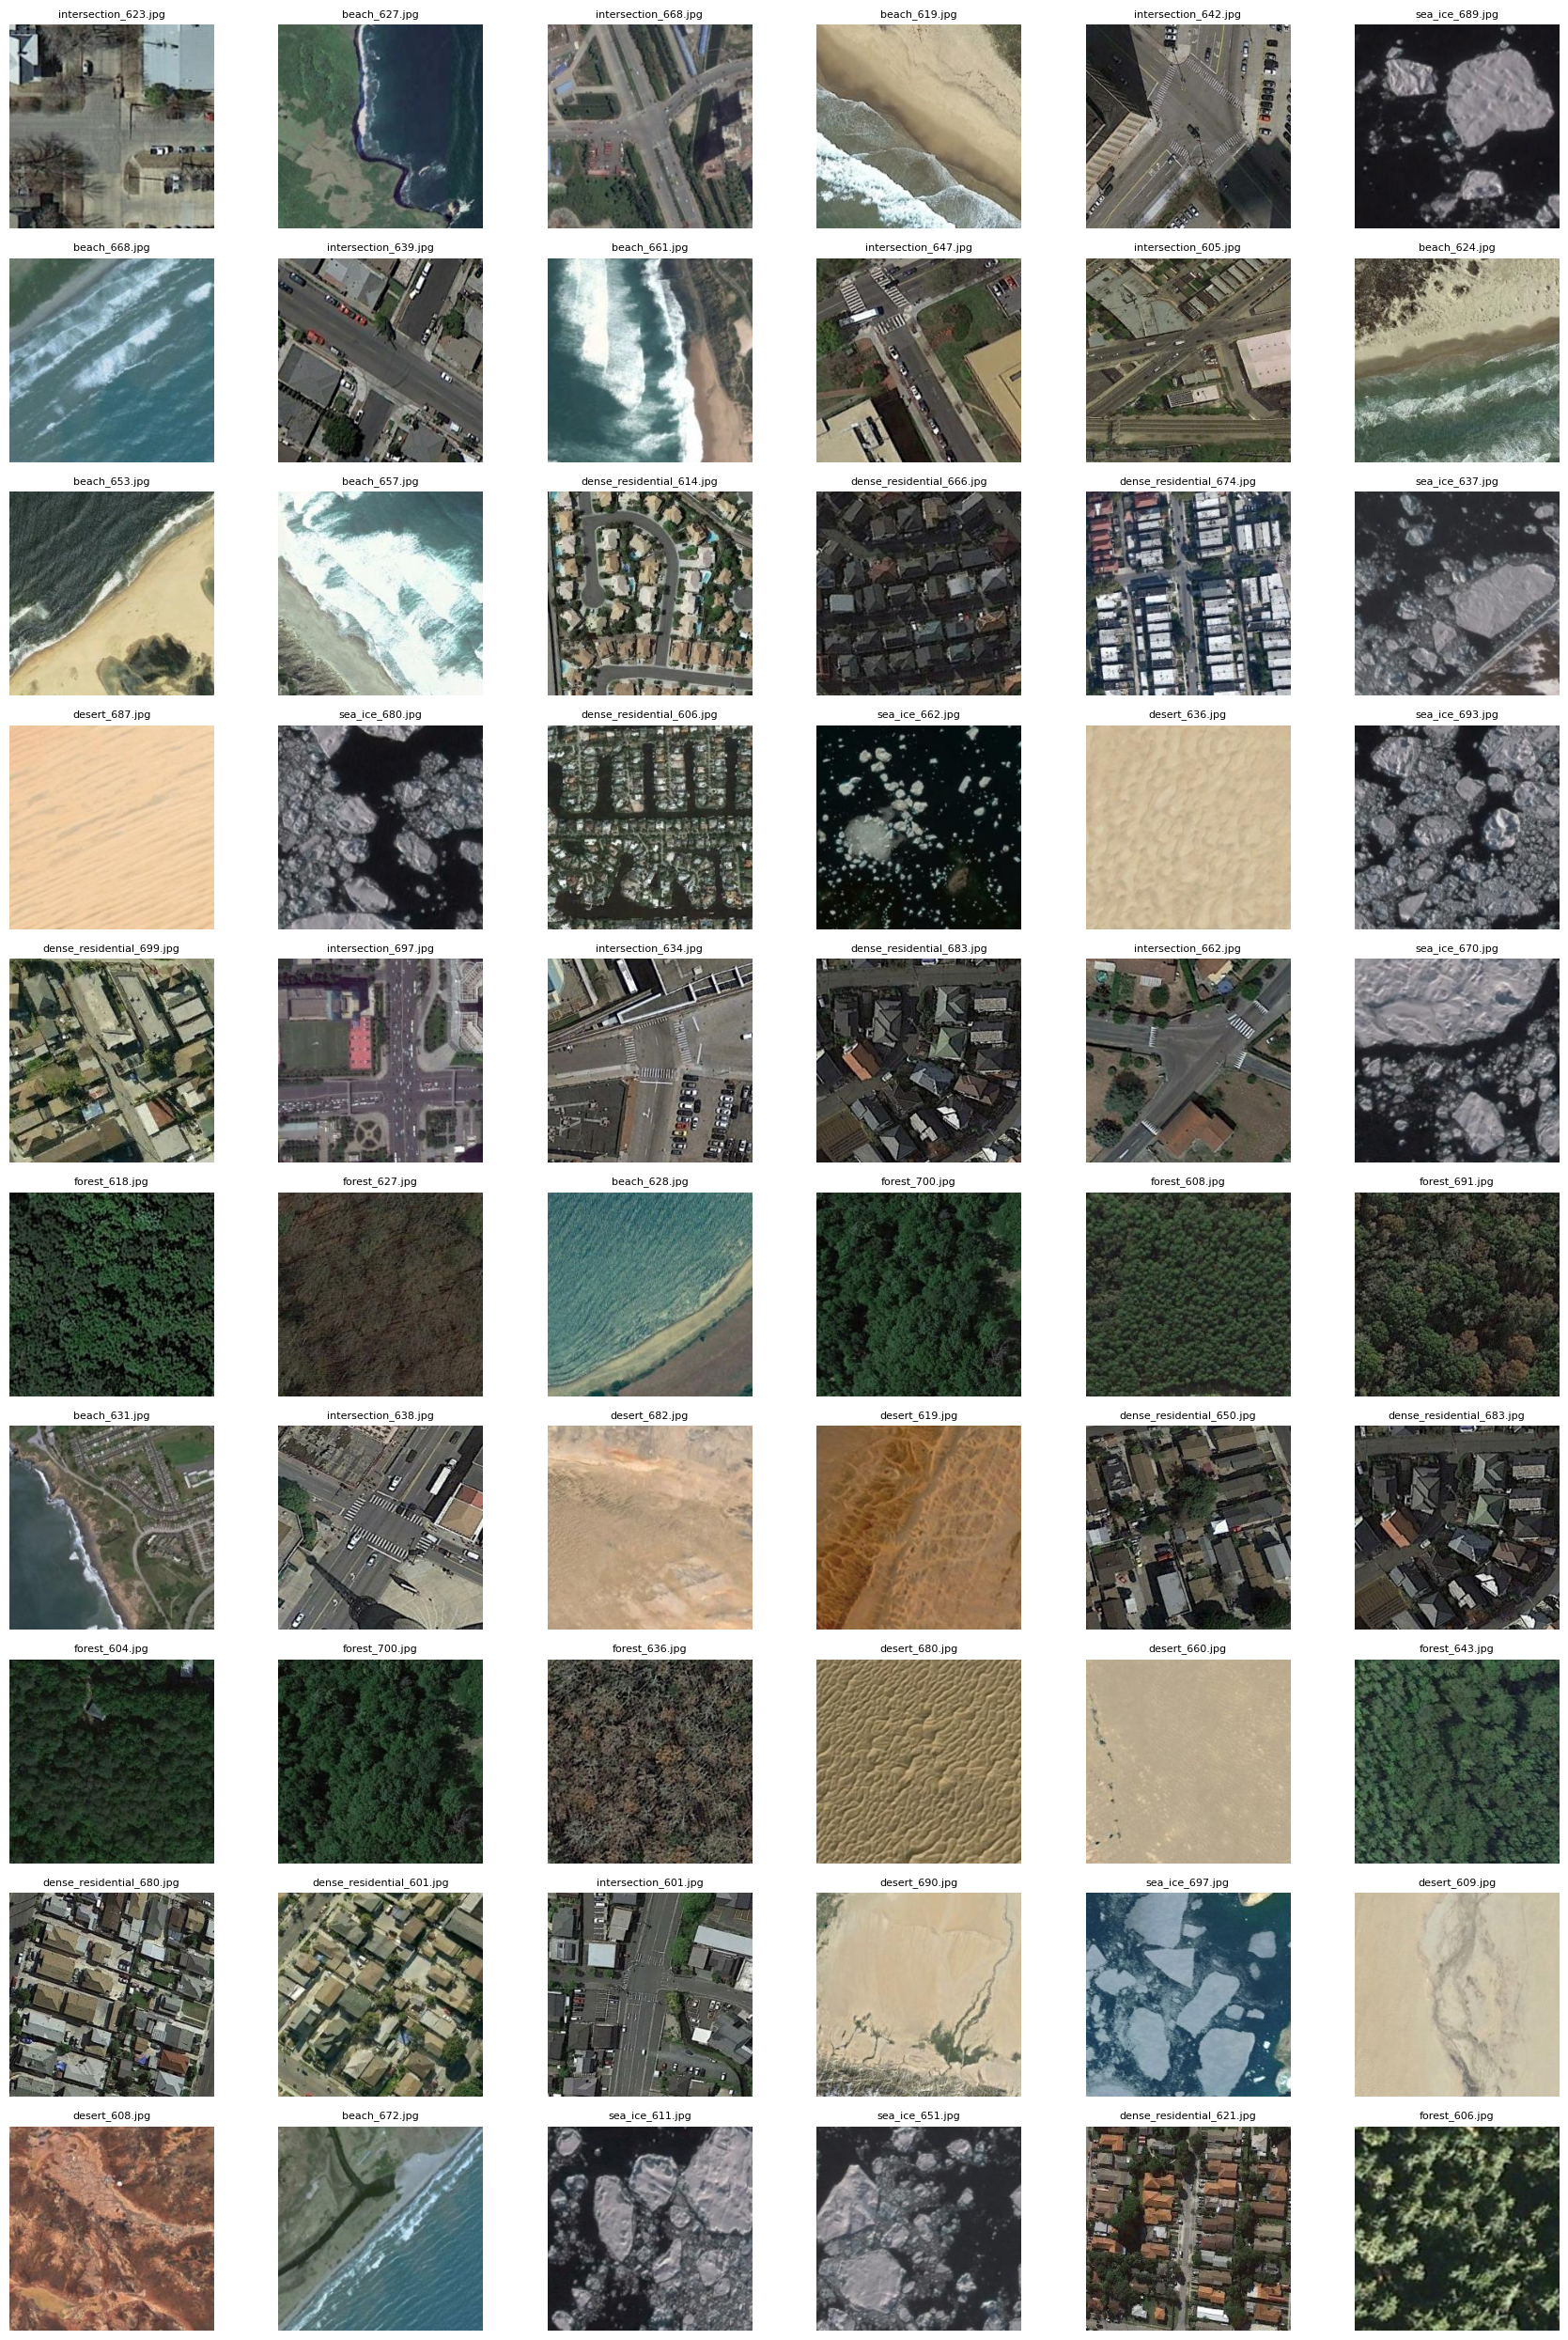

In [22]:
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict

# Load the test_with_cluster CSV
df = pd.read_csv("test_with_clusters.csv")

# Group images by their cluster
cluster_groups = defaultdict(list)
for _, row in df.iterrows():
    cluster_groups[row["cluster"]].append(row["image_name"])

# Ensure reproducibility
random.seed(42)

# Pick 10 images from different clusters (at least one from each)
selected_images = []
used_clusters = set()

# First, pick one image from each cluster
for cluster, images in cluster_groups.items():
    image = random.choice(images)
    selected_images.append((image, cluster))
    used_clusters.add(cluster)

# Fill the rest up to 10 randomly
remaining_needed = 10 - len(selected_images)
remaining_images = df[~df["image_name"].isin([img for img, _ in selected_images])]
additional_images = remaining_images.sample(n=remaining_needed, random_state=42)

for _, row in additional_images.iterrows():
    selected_images.append((row["image_name"], row["cluster"]))

# Prepare 10 rows, each with the selected image and 5 similar ones from the same cluster
image_grid = []

for image_name, cluster in selected_images:
    similar_images = [img for img in cluster_groups[cluster] if img != image_name]
    similar_samples = random.sample(similar_images, min(5, len(similar_images)))
    row_images = [image_name] + similar_samples
    image_grid.append((cluster, row_images))

# Search function to find image in test folder structure
def find_image_path(root_dir, filename):
    for root, _, files in os.walk(root_dir):
        if filename in files:
            return os.path.join(root, filename)
    return None

# Plotting
fig, axs = plt.subplots(nrows=10, ncols=6, figsize=(18, 25))
fig.subplots_adjust(hspace=0.5)

for row_idx, (cluster, image_names) in enumerate(image_grid):
    for col_idx, img_name in enumerate(image_names):
        img_path = find_image_path("test", img_name)
        if img_path:
            img = mpimg.imread(img_path)
            axs[row_idx, col_idx].imshow(img)
            axs[row_idx, col_idx].axis('off')
            axs[row_idx, col_idx].set_title(f"{img_name}", fontsize=8)
        else:
            axs[row_idx, col_idx].axis('off')
            axs[row_idx, col_idx].set_title("Not found", fontsize=8)

plt.tight_layout()
plt.show()
